In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

!sudo apt-get install -y xvfb ffmpeg
!pip install -q 'gym==0.19.0'
!pip install -q 'imageio==2.4.0'
!pip install -q PILLOW
!pip install -q 'pyglet==1.3.2'
!pip install -q pyvirtualdisplay
!pip install -q --upgrade tensorflow-probability
!pip install -q tf-agents
!pip install ale-py
# !pip install gym

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
     |████████████████████████████████| 1.6 MB 33.2 MB/s 


In [ ]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf
import ale_py 

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym, suite_atari
from tf_agents.environments import tf_py_environment, batched_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network, network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

In [ ]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [ ]:
num_iterations = 3000

initial_collect_steps = 200  
collect_steps_per_iteration = 10 
replay_buffer_max_length = 100000

batch_size =   32
learning_rate = 2.5e-3
log_interval =   5000

num_eval_episodes = 1
eval_interval = 25000  

max_episode_frames=108000
ATARI_FRAME_SKIP = 4

In [ ]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM
# ! python -m atari_py.import_roms /content/gdrive/MyDrive/IIS_Proekt

--2021-09-30 15:40:25--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar.4’

Roms.rar.4          100%[===================>]  10.61M   833KB/s    in 14s     

2021-09-30 15:40:38 (804 KB/s) - ‘Roms.rar.4’ saved [11128004/11128004]

mkdir: cannot create directory ‘/content/ROM/’: File exists

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar


Would you like to replace the existing file /content/ROM/HC ROMS.zip
11826711 bytes, modified on 2019-12-22 11:24
with a new one
11826711 bytes, modified on 2019-12-22 11:24

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit a

Extracting  /content/ROM/HC ROMS.zip                                      36%  OK 
Extracting  /conten

In [ ]:
#https://github.com/tensorflow/agents/blob/master/tf_agents/agents/categorical_dqn/examples/train_eval_atari.py
class AtariCategoricalQNetwork(network.Network):
  """CategoricalQNetwork subclass that divides observations by 255."""

  def __init__(self, input_tensor_spec, action_spec, **kwargs):
    super(AtariCategoricalQNetwork, self).__init__(
        input_tensor_spec, state_spec=())
    input_tensor_spec = tf.TensorSpec(
        dtype=tf.float32, shape=input_tensor_spec.shape)
    self._categorical_q_network = categorical_q_network.CategoricalQNetwork(
        input_tensor_spec, action_spec, **kwargs)

  @property
  def num_atoms(self):
    return self._categorical_q_network.num_atoms

  def call(self, observation, step_type=None, network_state=()):
    state = tf.cast(observation, tf.float32)
    # We divide the grayscale pixel values by 255 here rather than storing
    # normalized values beause uint8s are 4x cheaper to store than float32s.
    # TODO(b/129805821): handle the division by 255 for train_eval_atari.py in
    # a preprocessing layer instead.
    state = state / 255
    return self._categorical_q_network(
        state, step_type=step_type, network_state=network_state)
    
def compute_avg_return(environment, policy, num_episodes=10):
  total_return = 0.0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

#https://tensorflow.google.cn/agents/tutorials/9_c51_tutorial?hl=zh-cn 
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, eval_env, eval_py_env, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

In [ ]:
def get_simulation(name):

  env_name = name
  env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)
  env.reset()
  PIL.Image.fromarray(env.render())

  train_py_env = suite_atari.load(
      env_name,
      max_episode_steps=max_episode_frames,
      gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

  eval_py_env = suite_atari.load(
      env_name,
      max_episode_steps=max_episode_frames,
      gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

  train_env = tf_py_environment.TFPyEnvironment(train_py_env)
  eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

  fc_layer_params = (512,)
  conv_layer_params=((32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1))

  q_net = AtariCategoricalQNetwork(
              train_env.observation_spec(),
              train_env.action_spec(),
              conv_layer_params=conv_layer_params,
              fc_layer_params=fc_layer_params)
  
  optimizer = tf.compat.v1.train.AdamOptimizer(
      learning_rate=0.001, 
      beta1=0.9, 
      beta2=0.999, 
      epsilon=1e-08, 
      use_locking=False,
      name='Adam'
)

  train_step_counter = tf.Variable(0)

  observation_spec = tensor_spec.from_spec(train_env.observation_spec())
  time_step_spec = ts.time_step_spec(observation_spec)
  action_spec = tensor_spec.from_spec(train_env.action_spec())

  target_update_period=32000  # ALE frames
  update_period=16  # ALE frames
  _update_period = update_period / ATARI_FRAME_SKIP


  agent = categorical_dqn_agent.CategoricalDqnAgent(
      time_step_spec,
      action_spec,
      categorical_q_network=q_net,
      optimizer=optimizer,
      #epsilon_greedy=epsilon,
      n_step_update=1.0,
      target_update_tau=1.0,
      target_update_period=(
          target_update_period / ATARI_FRAME_SKIP / _update_period),
      gamma=0.99,
      reward_scale_factor=1.0,
      gradient_clipping=None,
      debug_summaries=False,
      summarize_grads_and_vars=False)

  agent.initialize()

  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
      data_spec=agent.collect_data_spec,
      batch_size=train_env.batch_size,
      max_length=replay_buffer_max_length)

  dataset = replay_buffer.as_dataset(
      num_parallel_calls=3, 
      sample_batch_size=batch_size, 
      num_steps=2).prefetch(3)

  random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                  train_env.action_spec())

  collect_data(train_env, random_policy, replay_buffer, \
              steps=initial_collect_steps)
    
  iterator = iter(dataset)
  agent.train = common.function(agent.train)
  agent.train_step_counter.assign(0)
  avg_return = compute_avg_return(eval_env, agent.policy, \
                                  num_eval_episodes)
  returns = [avg_return]

  for _ in range(num_iterations):
    for _ in range(collect_steps_per_iteration):
      collect_step(train_env, agent.collect_policy, replay_buffer)
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    step = agent.train_step_counter.numpy()
    if step % log_interval == 0:
      print('step = {0}: loss = {1}'.format(step, train_loss))
    if step % eval_interval == 0:
      avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
      print('step = {0}: Average Return = {1}'.format(step, avg_return))
      returns.append(avg_return)

  iterations = range(0, num_iterations + 1, eval_interval)
  plt.plot(iterations, returns)
  plt.ylabel('Average Return')
  plt.xlabel('Iterations')
  plt.ylim(top=10)

  return agent.policy,random_policy, eval_env,eval_py_env


Instructions for updating:
Use `tf.data.Dataset.scan(...) instead
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


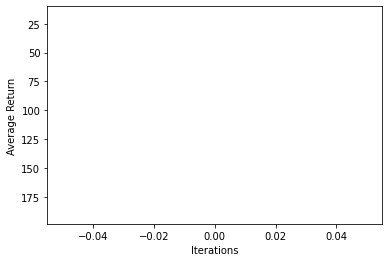

In [ ]:
agentpolicy,randompolicy,eval_env,eval_py_env = get_simulation('MsPacman-v0')

In [ ]:
create_policy_eval_video(agentpolicy, "trained-agent",eval_env,eval_py_env)

In [ ]:
create_policy_eval_video(randompolicy, "random-agent",eval_env,eval_py_env)

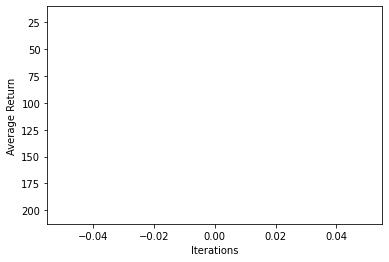

In [ ]:
agentpolicy,randompolicy,eval_env,eval_py_env = get_simulation('SpaceInvaders-v0')

In [ ]:
create_policy_eval_video(agentpolicy, "trained-agent",eval_env,eval_py_env)

In [ ]:
create_policy_eval_video(randompolicy, "random-agent",eval_env,eval_py_env)

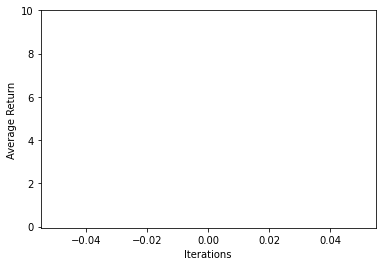

In [ ]:
agentpolicy,randompolicy,eval_env,eval_py_env = get_simulation('Breakout-v4')

In [ ]:
create_policy_eval_video(agentpolicy, "trained-agent",eval_env,eval_py_env)

In [ ]:
create_policy_eval_video(randompolicy, "random-agent",eval_env,eval_py_env)